# MNIST Handwritten Digit Classification

## Overview
This notebook implements a Convolutional Neural Network (CNN) for classifying handwritten digits from the MNIST dataset. The MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits (0-9), each 28x28 pixels in grayscale.

## Assignment Goals
- Build a lightweight CNN model with fewer than 20k parameters
- Achieve high accuracy (>99.4%) on the MNIST test set in less than 20epoch
- Implement proper data augmentation and regularization techniques
- Visualize training progress and model performance

## Import Required Libraries

We'll import all the necessary libraries for building and training our CNN model:
- **PyTorch**: Core deep learning framework
- **torchvision**: For datasets and image transforms
- **matplotlib**: For visualization
- **torchsummary**: For model paramter summerization


In [1]:
# Import core PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import vision libraries for datasets and transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import additional libraries for visualization and utilities
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os


from torchsummary import summary
from TrainingHelper import TrainingHelper
from Visualization import Visualization

## Device Setup and GPU Detection

We'll check for available compute devices in order of preference:
1. **CUDA** (NVIDIA GPUs) - Best performance for deep learning
2. **MPS** (Apple Silicon Metal) - Optimized for Mac M1/M2/M3 chips
3. **CPU** - Fallback option for compatibility

This ensures optimal performance across different hardware configurations.


In [2]:
# Set the device for training
device = TrainingHelper.get_device()
print(f"Device selected: {device}")

# Set the seed for reproducibility
TrainingHelper.set_seed(42)

✅ Using Apple Silicon GPU (Metal Performance Shaders)
Device selected: mps
🌱 Random seed set to 42


## Data Preprocessing and Augmentation

### Training Transforms
We apply several augmentation techniques to increase dataset diversity and improve model generalization:
- **RandomRotation(10°)**: Slight rotations to handle natural writing variations
- **RandomAffine**: Translation, scaling, and shearing transforms
- **ColorJitter**: Brightness and contrast variations
- **Normalization**: Using MNIST statistics (mean=0.1307, std=0.3081)

### Test Transforms  
For testing, we only apply normalization to ensure consistent preprocessing while maintaining reproducible results.


In [3]:
# Define data transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Define data transformations for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Dataset Loading and Data Loaders

We'll download and prepare the MNIST dataset with appropriate batch sizes for training:
- **Batch size**: 32 (balances memory usage and gradient stability)
- **Shuffle**: Training data shuffled for better convergence
- **Workers**: Multiple workers for parallel data loading


In [4]:
# Load MNIST datasets with transforms
train_dataset = datasets.MNIST(
    root='./data',              # Directory to store/load data
    train=True,                 # Load training set
    download=True,              # Download if not present
    transform=train_transform   # Apply training transforms
)

test_dataset = datasets.MNIST(
    root='./data',              # Directory to store/load data
    train=False,                # Load test set
    download=True,              # Download if not present  
    transform=test_transform    # Apply test transforms
)

# Create data loaders for batch processing
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,              # Process 32 images per batch
    shuffle=True,               # Randomize order for each epoch
    num_workers=2,              # Parallel data loading
    pin_memory=True if device.type != 'cpu' else False  # Optimize GPU memory transfer
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=32,              # Same batch size for consistency
    shuffle=False,              # Keep order for reproducible results
    num_workers=2,              # Parallel data loading
    pin_memory=True if device.type != 'cpu' else False  # Optimize GPU memory transfer
)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training samples: 60,000
Test samples: 10,000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])


## Data Visualization and Exploration

Let's examine our training data to understand what we're working with:
- **Sample Images**: Visualize a batch of training images
- **Data Shape**: Confirm tensor dimensions (batch_size, channels, height, width)  
- **Label Distribution**: Understand class balance in the dataset
- **Augmentation Effects**: See how data transforms affect the images

This visualization helps ensure our data loading pipeline is working correctly and gives us insight into the dataset characteristics.


/opt/anaconda3/envs/era_v4/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 Dataset Information:
Batch shape: torch.Size([32, 1, 28, 28])
Label shape: torch.Size([32])
Data type: torch.float32
Pixel value range: [-0.424, 2.821]


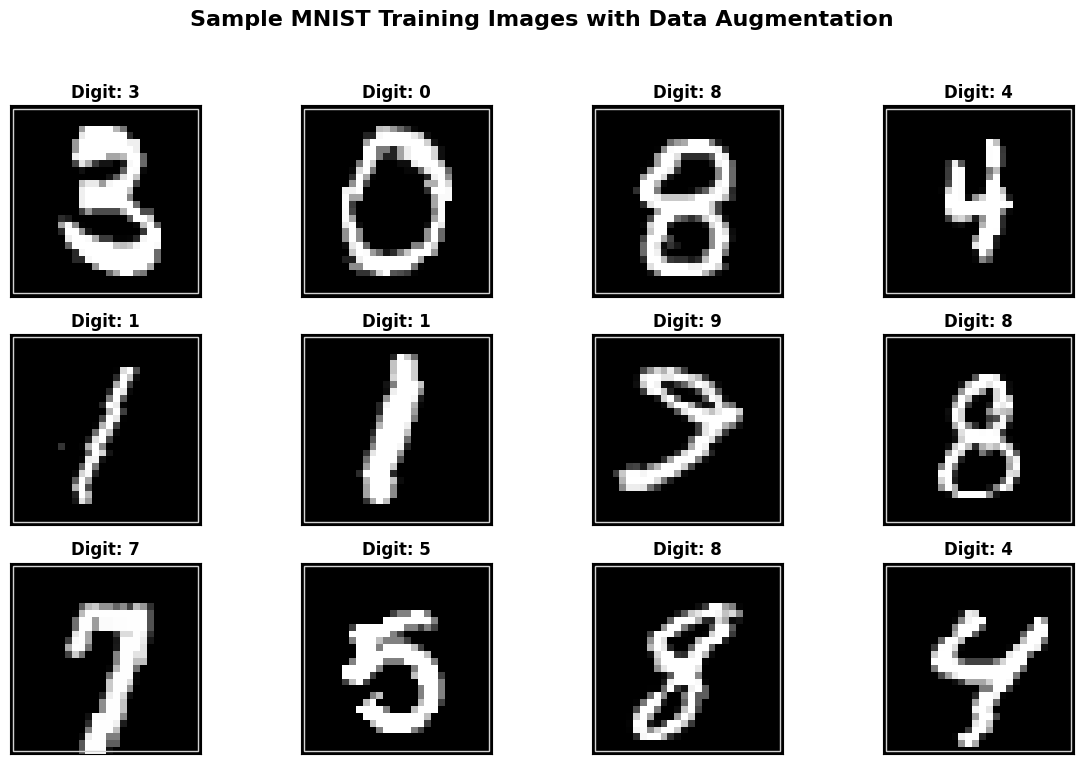


📈 Batch Statistics:
Unique labels in batch: [0, 1, 2, 3, 4, 5, 7, 8, 9]
  Digit 0: 7 images
  Digit 1: 5 images
  Digit 2: 2 images
  Digit 3: 1 images
  Digit 4: 4 images
  Digit 5: 3 images
  Digit 7: 3 images
  Digit 8: 5 images
  Digit 9: 2 images


In [5]:
# Get a sample batch from the training data loader
batch_data, batch_labels = next(iter(train_loader))

print("📊 Dataset Information:")
print(f"Batch shape: {batch_data.shape}")
print(f"Label shape: {batch_labels.shape}")
print(f"Data type: {batch_data.dtype}")
print(f"Pixel value range: [{batch_data.min():.3f}, {batch_data.max():.3f}]")

# Create a figure to display sample images
plt.figure(figsize=(12, 8))
plt.suptitle('Sample MNIST Training Images with Data Augmentation', 
             fontsize=16, fontweight='bold', y=0.98)

# Display a grid of 12 sample images (3 rows × 4 columns)
num_samples = 12
for i in range(num_samples):
    plt.subplot(3, 4, i + 1)  # Create subplot in 3x4 grid
    
    # Display the image
    image = batch_data[i].squeeze(0)  # Remove channel dimension for display
    plt.imshow(image, cmap='gray', interpolation='nearest')
    
    # Add title showing the digit label
    digit_label = batch_labels[i].item()
    plt.title(f'Digit: {digit_label}', fontsize=12, fontweight='bold')
    
    # Remove axis ticks for cleaner appearance
    plt.xticks([])
    plt.yticks([])
    
    # Add subtle border around each image
    plt.gca().add_patch(plt.Rectangle((0, 0), 27, 27, fill=False, 
                                     edgecolor='lightgray', linewidth=1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

# Display statistics about the current batch
print(f"\n📈 Batch Statistics:")
print(f"Unique labels in batch: {sorted(torch.unique(batch_labels).tolist())}")
unique_labels, counts = torch.unique(batch_labels, return_counts=True)
for label, count in zip(unique_labels.tolist(), counts.tolist()):
    print(f"  Digit {label}: {count} images")

## CNN Model Architecture

Our **SmallMNISTNet4Block** is designed to be efficient yet powerful, staying under 25,000 parameters while achieving high accuracy.

### Architecture Design Philosophy:
- **Progressive Channel Reduction**: Each block processes features at different abstraction levels
- **Transition Layers**: 1×1 convolutions reduce parameters and control information flow
- **Strategic Dropout**: Applied at key points to prevent overfitting
- **Global Average Pooling**: Replaces fully connected layers to reduce parameters
- **Efficient Parameter Usage**: Every layer contributes meaningfully to the final result

### Model Flow:
```
Input (1×28×28) 
↓ Block 1: Feature extraction (1→8→16→32→16 channels) + MaxPool + Dropout
↓ Block 2: Pattern recognition (16→32→8 channels) + MaxPool + Dropout  
↓ Block 3: High-level features (8→16 channels) + MaxPool + Dropout
↓ Block 4: Final refinement (16→32 channels)
↓ Global Average Pooling (32×1×1)
↓ Linear Classification (32→10)
↓ Output (10 classes)
```


In [6]:
class SmallMNISTNet4Block(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(SmallMNISTNet4Block, self).__init__()

        # ------- Block 1 -------
        self.conv1_1 = nn.Conv2d(1, 6, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(6)
        self.conv1_2 = nn.Conv2d(6, 12, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(12)
        self.conv1_3 = nn.Conv2d(12, 24, 3, padding=1)
        self.bn1_3 = nn.BatchNorm2d(24)
        self.trans1 = nn.Conv2d(24, 8, 1)
        self.bn1_trans = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout2d(dropout_prob)

        # ------- Block 2 -------
        self.conv2_1 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(16)
        self.conv2_2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(16)
        self.trans2 = nn.Conv2d(16, 8, 1)
        self.bn2_trans = nn.BatchNorm2d(8)
        self.dropout2 = nn.Dropout2d(dropout_prob)

        # ------- Block 3 -------
        self.conv3_1 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(16)
        self.conv3_2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(16)
        self.dropout3 = nn.Dropout2d(dropout_prob)

        # ------- Block 4 -------
        self.conv4_1 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(16)
        self.conv4_2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(32)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Final classifier
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn1_3(self.conv1_3(x)))
        x = F.relu(self.bn1_trans(self.trans1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.relu(self.bn2_trans(self.trans2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = F.max_pool2d(x, 2)
        #x = self.dropout3(x)

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))

        # Global Average Pooling
        x = self.gap(x)

        # Flatten + classifier
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


## Model Summary and Parameter Analysis

Let's analyze our model architecture and verify it meets our parameter constraints:
- **Total Parameters**: Should be < 20k
- **Memory Usage**: Efficient forward/backward pass
- **Layer Distribution**: Balanced parameter allocation across blocks


In [7]:
model = SmallMNISTNet4Block().to('cpu')
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
       BatchNorm2d-2            [-1, 6, 28, 28]              12
            Conv2d-3           [-1, 12, 28, 28]             660
       BatchNorm2d-4           [-1, 12, 28, 28]              24
            Conv2d-5           [-1, 24, 28, 28]           2,616
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7            [-1, 8, 28, 28]             200
       BatchNorm2d-8            [-1, 8, 28, 28]              16
         Dropout2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,168
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
           Conv2d-14            [-1, 8,

### Training Configuration:
- **Optimizer**: Adam with adaptive learning rate
- **Loss Function**: CrossEntropyLoss for multi-class classification


In [8]:
print("=" * 50)

config, training_history, checkpoint_paths = TrainingHelper.setup_training_config(
    num_epochs=20, 
    early_stopping_patience=10, 
    min_delta=0.001,
    save_best_only=True,
    checkpoint_dir="./checkpoints")

best_model_path = checkpoint_paths['best_model']
checkpoint_path = checkpoint_paths['latest_checkpoint']

# Initialize model with optimal settings
model = SmallMNISTNet4Block(dropout_prob=0.1).to(device)

# Configure optimizer with optimal hyperparameters
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.001
)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler for adaptive learning
scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=7,           # Reduce LR every 7 epochs
    gamma=0.1              # Multiply LR by 0.1
)

# Initialize tracking variables
best_test_accuracy = 0.0
patience_counter = 0
start_epoch = 0

print(f"🎯 Training Configuration:")
print(f"  Device: {device}")
print(f"  Optimizer: Adam (lr={optimizer.param_groups[0]['lr']}, weight_decay={optimizer.param_groups[0]['weight_decay']})")
print(f"  Loss function: {criterion.__class__.__name__}")
print(f"  Scheduler: StepLR (step_size=7, gamma=0.1)")
print(f"  Epochs: {config['num_epochs']}")
print(f"  Early stopping patience: {config['early_stopping_patience']}")


📁 Training Setup Complete:
  Epochs: 20
  Early stopping patience: 10
  Checkpoint directory: ./checkpoints
  Best model path: ./checkpoints/best_mnist_model.pth
  Latest checkpoint: ./checkpoints/latest_checkpoint.pth
🎯 Training Configuration:
  Device: mps
  Optimizer: Adam (lr=0.001, weight_decay=0)
  Loss function: CrossEntropyLoss
  Scheduler: StepLR (step_size=7, gamma=0.1)
  Epochs: 20
  Early stopping patience: 10


In [9]:
# 🚀 Training Loop with Comprehensive Tracking
print("\n🚀 Starting Training Process")
print("=" * 60)

print(str(config['num_epochs']) + " epochs" + " starting from epoch " + str(start_epoch))

# Training loop with enhanced features
for epoch in range(start_epoch, config['num_epochs']):
    current_epoch = epoch + 1
    print(f"\n📈 Epoch {current_epoch}/{config['num_epochs']}")
    print("-" * 40)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Training phase
    train_loss, train_accuracy = TrainingHelper.train_epoch(
        model, device, train_loader, optimizer, criterion, current_epoch
    )
    
    # Testing/Validation phase
    test_loss, test_accuracy = TrainingHelper.evaluate_model(
        model, device, test_loader, criterion, "Test"
    )
    
    # Update learning rate scheduler
    scheduler.step()
    
    # Store metrics in training history
    training_history['epochs'].append(current_epoch)
    training_history['train_losses'].append(train_loss)
    training_history['train_accuracies'].append(train_accuracy)
    training_history['test_losses'].append(test_loss)
    training_history['test_accuracies'].append(test_accuracy)
    training_history['learning_rates'].append(current_lr)
    
    # Check for improvement and save best model
    improvement = test_accuracy - best_test_accuracy
    if improvement > config['min_delta']:
        best_test_accuracy = test_accuracy
        patience_counter = 0
        
        # Save best model
        TrainingHelper.save_checkpoint(
            model, optimizer, current_epoch, test_loss, test_accuracy, best_model_path
        )
        print(f"🏆 New best model! Test accuracy: {test_accuracy:.2f}%")
    else:
        patience_counter += 1
        print(f"📊 No improvement (patience: {patience_counter}/{config['early_stopping_patience']})")

    # Save latest checkpoint
    TrainingHelper.save_checkpoint(
        model, optimizer, current_epoch, test_loss, test_accuracy, checkpoint_path
    )
    
    # Early stopping check
    if patience_counter >= config['early_stopping_patience']:
        print(f"\n⏹️  Early stopping triggered after {current_epoch} epochs")
        print(f"   Best test accuracy: {best_test_accuracy:.2f}%")
        break
    
    # Display epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || Test Loss:  {test_loss:.4f} | Test Acc:  {test_accuracy:.2f}% || Learning Rate: {current_lr:.6f}")

print(f"\n✅ Training Complete!")
print(f"   Best test accuracy: {best_test_accuracy:.2f}%")
print(f"   Total epochs trained: {len(training_history['epochs'])}")


🚀 Starting Training Process
20 epochs starting from epoch 0

📈 Epoch 1/20
----------------------------------------


🏆 New best model! Test accuracy: 98.76%
Train Loss: 0.3508 | Train Acc: 90.31% || Test Loss:  0.0393 | Test Acc:  98.76% || Learning Rate: 0.001000

📈 Epoch 2/20
----------------------------------------


🏆 New best model! Test accuracy: 98.78%
Train Loss: 0.1045 | Train Acc: 96.81% || Test Loss:  0.0367 | Test Acc:  98.78% || Learning Rate: 0.001000

📈 Epoch 3/20
----------------------------------------


🏆 New best model! Test accuracy: 98.96%
Train Loss: 0.0863 | Train Acc: 97.40% || Test Loss:  0.0312 | Test Acc:  98.96% || Learning Rate: 0.001000

📈 Epoch 4/20
----------------------------------------


📊 No improvement (patience: 1/10)
Train Loss: 0.0783 | Train Acc: 97.57% || Test Loss:  0.0320 | Test Acc:  98.93% || Learning Rate: 0.001000

📈 Epoch 5/20
----------------------------------------


🏆 New best model! Test accuracy: 99.18%
Train Loss: 0.0702 | Train Acc: 97.86% || Test Loss:  0.0246 | Test Acc:  99.18% || Learning Rate: 0.001000

📈 Epoch 6/20
----------------------------------------


🏆 New best model! Test accuracy: 99.23%
Train Loss: 0.0652 | Train Acc: 98.03% || Test Loss:  0.0222 | Test Acc:  99.23% || Learning Rate: 0.001000

📈 Epoch 7/20
----------------------------------------


📊 No improvement (patience: 1/10)
Train Loss: 0.0606 | Train Acc: 98.12% || Test Loss:  0.0236 | Test Acc:  99.17% || Learning Rate: 0.001000

📈 Epoch 8/20
----------------------------------------


🏆 New best model! Test accuracy: 99.44%
Train Loss: 0.0459 | Train Acc: 98.56% || Test Loss:  0.0166 | Test Acc:  99.44% || Learning Rate: 0.000100

📈 Epoch 9/20
----------------------------------------


📊 No improvement (patience: 1/10)
Train Loss: 0.0411 | Train Acc: 98.72% || Test Loss:  0.0176 | Test Acc:  99.40% || Learning Rate: 0.000100

📈 Epoch 10/20
----------------------------------------


📊 No improvement (patience: 2/10)
Train Loss: 0.0394 | Train Acc: 98.73% || Test Loss:  0.0158 | Test Acc:  99.43% || Learning Rate: 0.000100

📈 Epoch 11/20
----------------------------------------


📊 No improvement (patience: 3/10)
Train Loss: 0.0395 | Train Acc: 98.79% || Test Loss:  0.0157 | Test Acc:  99.42% || Learning Rate: 0.000100

📈 Epoch 12/20
----------------------------------------


🏆 New best model! Test accuracy: 99.49%
Train Loss: 0.0386 | Train Acc: 98.82% || Test Loss:  0.0142 | Test Acc:  99.49% || Learning Rate: 0.000100

📈 Epoch 13/20
----------------------------------------


🏆 New best model! Test accuracy: 99.51%
Train Loss: 0.0387 | Train Acc: 98.81% || Test Loss:  0.0145 | Test Acc:  99.51% || Learning Rate: 0.000100

📈 Epoch 14/20
----------------------------------------


🏆 New best model! Test accuracy: 99.52%
Train Loss: 0.0363 | Train Acc: 98.91% || Test Loss:  0.0151 | Test Acc:  99.52% || Learning Rate: 0.000100

📈 Epoch 15/20
----------------------------------------


🏆 New best model! Test accuracy: 99.55%
Train Loss: 0.0387 | Train Acc: 98.82% || Test Loss:  0.0149 | Test Acc:  99.55% || Learning Rate: 0.000010

📈 Epoch 16/20
----------------------------------------


📊 No improvement (patience: 1/10)
Train Loss: 0.0360 | Train Acc: 98.89% || Test Loss:  0.0146 | Test Acc:  99.53% || Learning Rate: 0.000010

📈 Epoch 17/20
----------------------------------------


📊 No improvement (patience: 2/10)
Train Loss: 0.0347 | Train Acc: 98.89% || Test Loss:  0.0144 | Test Acc:  99.52% || Learning Rate: 0.000010

📈 Epoch 18/20
----------------------------------------


📊 No improvement (patience: 3/10)
Train Loss: 0.0361 | Train Acc: 98.86% || Test Loss:  0.0146 | Test Acc:  99.51% || Learning Rate: 0.000010

📈 Epoch 19/20
----------------------------------------


📊 No improvement (patience: 4/10)
Train Loss: 0.0354 | Train Acc: 98.91% || Test Loss:  0.0145 | Test Acc:  99.52% || Learning Rate: 0.000010

📈 Epoch 20/20
----------------------------------------


📊 No improvement (patience: 5/10)
Train Loss: 0.0357 | Train Acc: 98.86% || Test Loss:  0.0149 | Test Acc:  99.50% || Learning Rate: 0.000010

✅ Training Complete!
   Best test accuracy: 99.55%
   Total epochs trained: 20


### Training Analysis


📊 Training History Visualization
✅ Training history found with 20 epochs
📊 Combined metrics plot saved to combined_metrics.png


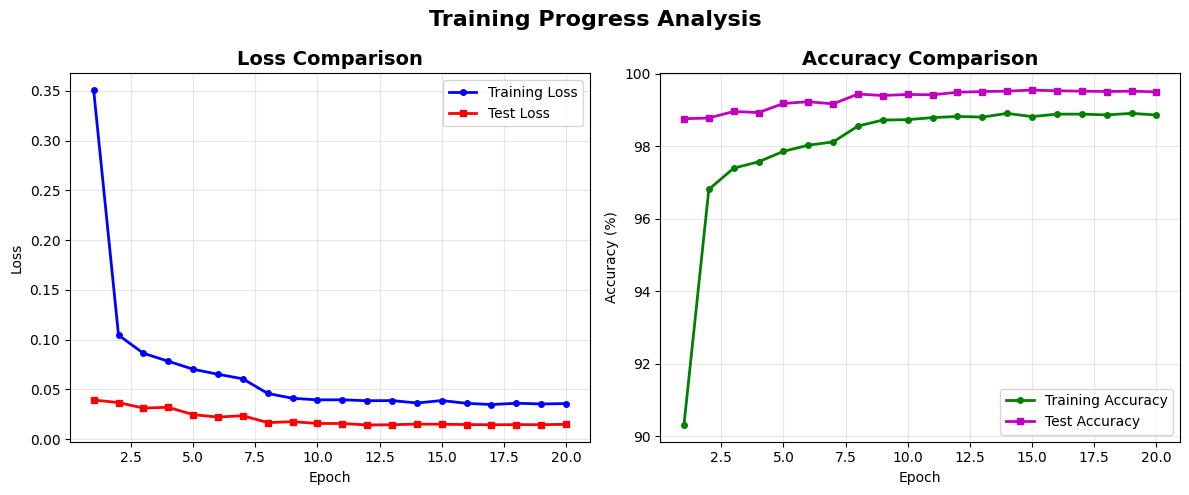

📊 Learning rate schedule plot saved to learning_rate_schedule.png


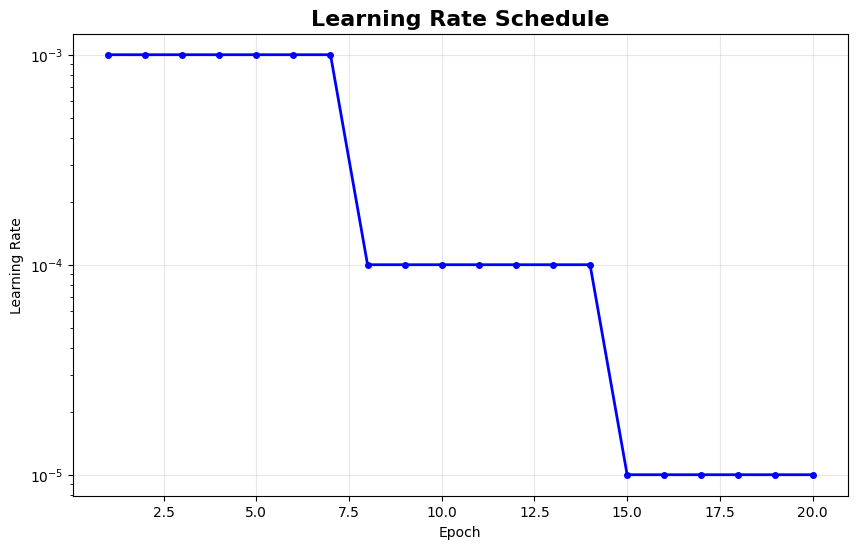

In [10]:
# Add plotting cell at the end using Visualization class
print("\n📊 Training History Visualization")
print("=" * 50)

# Check if training history exists and has data
if training_history['epochs']:
    print(f"✅ Training history found with {len(training_history['epochs'])} epochs")
    
    # Plot 2: Combined metrics (side-by-side) using Visualization class
    Visualization.plot_combined_metrics(training_history, save_path='combined_metrics.png')
    
    # Plot 3: Learning rate schedule
    Visualization.plot_learning_rate_schedule(training_history, save_path='learning_rate_schedule.png')
    
else:
    print("❌ No training history found. Please run training first.")
    print("Available variables:", [var for var in locals() if 'train' in var.lower() or 'test' in var.lower()])
